In [120]:
#save raw image (cropped), "-ch2", and "ch2_Simple Segmentation"
#Simple Segmentation comes from an ilastik classifier trained with ch2, exported masks as numpy(npy)
#the code takes 3x3 center pixels vs 3 pxl-wide contour of the mask to calculate nuclear/cyto ratio for modERK quantification

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tifffile import imread  
from scipy.ndimage import binary_fill_holes, binary_erosion, center_of_mass, binary_dilation, uniform_filter1d, gaussian_filter1d



### for images with Mesp in Channel 3 and modERK in Channel 2

In [136]:
def extract_contour_by_erosion(mask, width=3):
    """
    Extract a 2-pixel wide contour by eroding the original mask and subtracting it from the mask.
    
    Parameters:
    - mask: np.array, the binary mask.
    - width: int, number of pixels to erode (default: 2).
    
    Returns:
    - contour: np.array, the binary contour of the mask.
    """
    # Step 1: Erode the mask by 'width' pixels
    mask = binary_erosion(mask, iterations=2) # to erode the mask before defining contour (optional)
    eroded_mask = binary_erosion(mask, iterations=width)  
    # Step 2: Subtract the eroded mask from the original mask to get the contour
    contour = mask.astype(np.uint8) - eroded_mask.astype(np.uint8)
    
    return contour

def create_central_region_mask(h, w, center_h, center_w, size=3):
    """
    Create a mask for the central region with a specified size (default 3x3).
    """
    central_region_mask = np.zeros((h, w), dtype=np.uint8)
    half_size = size // 2
    central_region_mask[center_h-half_size:center_h+half_size+1, center_w-half_size:center_w+half_size+1] = 1
    return central_region_mask

def read_tif_and_mask(image_path, mask_path, file_name, time_interval=10):
    # Read the 3-channel TIF file
    image = imread(image_path)
    
    # Load the mask NumPy array
    mask = np.load(mask_path)
    
    # Binarize the mask (bg=2 and mask=1 in original array)
    mask = np.where(mask == 2, 0, mask)

    # Fill holes in the mask
    mask_filled = np.zeros_like(mask)
    for t in range(mask.shape[0]):  # Fill holes for each time frame
        mask_filled[t] = binary_fill_holes(mask[t]).astype(np.uint8)
      
    # Initialize lists to store masks and results for each time point
    central_region_mask_list = []
    contour_mask_list = []
    ratio_list = []
    channel_3_avg_list = []

    num_timepoints = image.shape[0]
    
    # Process each time point
    for t in range(num_timepoints):
        # Get the current mask for this time point
        current_mask = mask_filled[t]
        current_mask = current_mask[:, :, 0]
        
        # Step 1: Calculate the center of mass for the current frame
        h, w = current_mask.shape
        com_h, com_w = center_of_mass(current_mask)
        com_h, com_w = int(com_h), int(com_w)  # Convert to integers
        
        # Step 2: Create the central region mask for the current frame
        central_region_mask = create_central_region_mask(h, w, com_h, com_w, size=5)
        central_region_mask_list.append(central_region_mask)
        
        # Step 3: Extract the contour mask for the current frame
        contour_mask = extract_contour_by_erosion(current_mask, width=3)
        contour_mask_list.append(contour_mask)
        
        # Get the current frame of the image (Channel 2 and Channel 3)
        current_frame_channel_2 = image[t, 1, :, :]
        current_frame_channel_3 = image[t, 2, :, :]
        
        # Calculate average intensity in the central region and contour region (Channel 2)
        central_avg_intensity = np.mean(current_frame_channel_2[central_region_mask == 1])
        contour_avg_intensity = np.mean(current_frame_channel_2[contour_mask == 1])
        
        # Calculate the ratio for Channel 2 and append it to the list
        if contour_avg_intensity != 0:
            ratio = central_avg_intensity / contour_avg_intensity
        else:
            ratio = np.nan  # Avoid division by zero
        ratio_list.append(ratio)
        
        # Calculate the average intensity in the central region for Channel 3
        channel_3_avg_intensity = np.mean(current_frame_channel_3[central_region_mask == 1])
        channel_3_avg_list.append(channel_3_avg_intensity)
    
    return num_timepoints, ratio_list, channel_3_avg_list, central_region_mask_list, contour_mask_list


In [137]:
image = imread('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0098/ilastik/'+'wscepfl0098_xy001-1.tif')
image.shape

(39, 3, 92, 92)

In [205]:
def process_all_files_in_folder(folder_path):
    """
    Reads all 3-channel TIF files and corresponding mask files in a folder.
    TIF files must end with '-1.tif', and mask files must have a corresponding
    '-ch2_Simple Segmentation.npy' in their name.
    
    Parameters:
    - folder_path: str, path to the folder containing the TIF and mask files.
    
    Returns:
    - result_dict: dict, a dictionary where the key is the file name and the 
      value is another dictionary containing num_timepoints, ratio_list, 
      channel_3_avg_list, central_region_mask_list, and contour_mask_list.
    """
    
    # Initialize an empty dictionary to store results
    result_dict = {}
    
    # Loop over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('-1.tif'):
            # Construct the full path to the TIF file
            image_path = os.path.join(folder_path, file_name)
            
            # Find the corresponding mask file (replace '.tif' with '-ch2_Simple Segmentation.npy')
            mask_file_name = file_name.replace('.tif', '-ch2_Simple Segmentation.npy')
            mask_path = os.path.join(folder_path, mask_file_name)
            
            if os.path.exists(mask_path):
                # Call the function to read and get the values
                num_timepoints, ratio_list, channel_3_avg_list, central_region_mask_list, contour_mask_list = read_tif_and_mask(image_path, mask_path, file_name)
                
                # Store the values in the dictionary with the file name as key
                result_dict[file_name] = {
                    'num_timepoints': num_timepoints,
                    'ratio_list': ratio_list,
                    'channel_3_avg_list': channel_3_avg_list,
                    'central_region_mask_list': central_region_mask_list,
                    'contour_mask_list': contour_mask_list
                }
            else:
                print(f"Mask not found for: {file_name}")
    
    # Return the result dictionary
    return result_dict

# Call the function and store the result
result = process_all_files_in_folder('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0098/ilastik')
result_pd17 = process_all_files_in_folder('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0098/ilastik-pd17')

# Now `result` contains all the processed data in a dictionary structure.


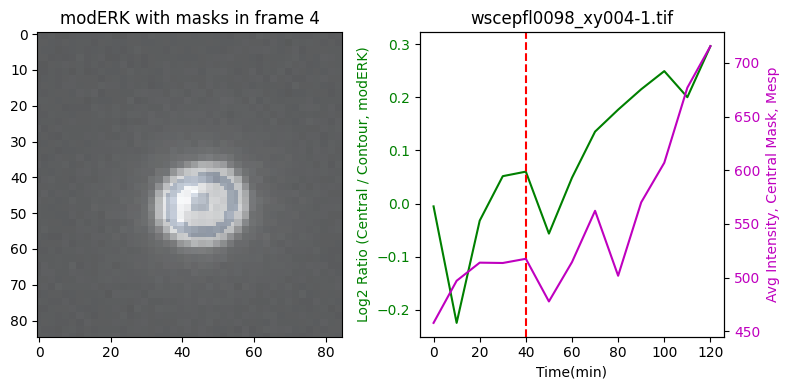

In [142]:
# enter the frame number and time point you want to visualize
position_nu = 3
time_point = 4
time_interval =10


keys_list = list(result.keys())
num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
ratio_list = result[keys_list[position_nu]]['ratio_list']
channel_3_avg_list = result[keys_list[position_nu]]['channel_3_avg_list']

# Step 1: Plot the first frame (Channel 2) with contour and central mask from the first frame
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
# Display the frame of the TIF file (Channel 2)
image = imread('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0098/ilastik/'+keys_list[position_nu])
current_frame_channel_2 = image[time_point, 1, :, :]
axes[0].imshow(current_frame_channel_2, cmap='gray')
    
# Overlay the central region with transparency
axes[0].imshow(result[keys_list[position_nu]]['central_region_mask_list'][time_point], cmap='Blues', alpha=0.2)
    
# Overlay the contour with transparency
axes[0].imshow(result[keys_list[position_nu]]['contour_mask_list'][time_point], cmap='Blues', alpha=0.2)   
axes[0].set_title(f'modERK with masks in frame {time_point:.0f}')



# Step 2: Plot the central-to-contour intensity ratio over time in log2 scale
ax1 = axes[1]  # First y-axis
ax1.plot(np.array(num_timepoints)*time_interval, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
ax1.set_xlabel('Time(min)')
ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
ax1.tick_params(axis='y', labelcolor='g')
# Add a vertical line at the specified time point
ax1.axvline(x=time_point * time_interval, color='r', linestyle='--', label='Time Point Line')

# Step 3: Create a second y-axis for Channel 3 average intensity
ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis
ax2.plot(np.array(num_timepoints)*time_interval, channel_3_avg_list, color='m', label='Avg Intensity, Central Mask, Ch3')
ax2.set_ylabel('Avg Intensity, Central Mask, Mesp', color='m')
ax2.tick_params(axis='y', labelcolor='m')
    
# Final touches for the plot
ax1.set_title(keys_list[position_nu])
fig.tight_layout()  # Adjust layout so that labels don't overlap
    
plt.show()

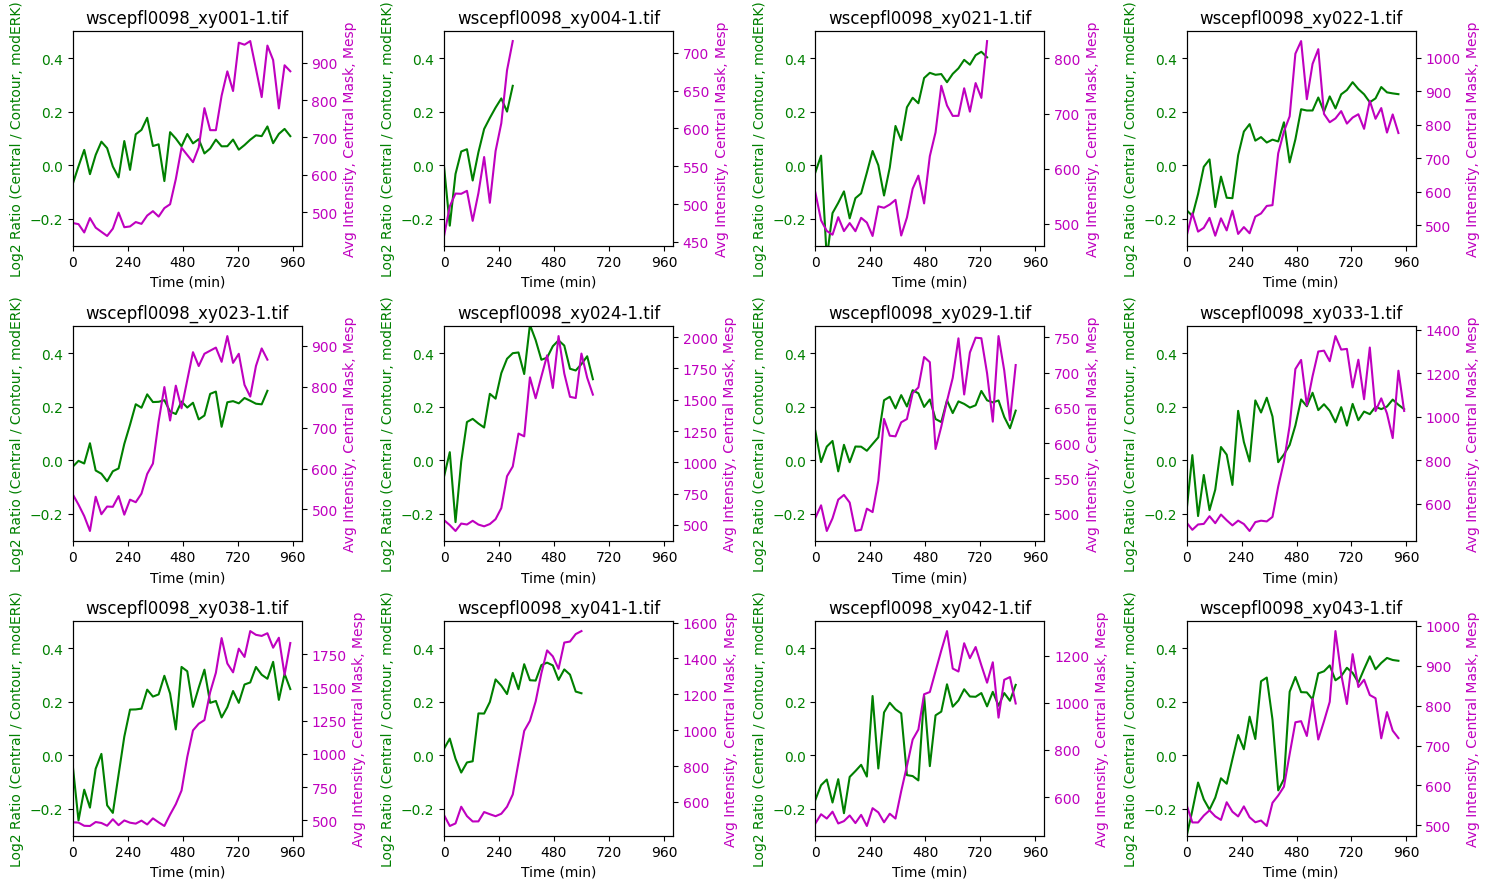

In [143]:
#plot all cells

time_interval = 25

# Get all keys in the result dictionary
keys_list = sorted(result.keys())
num_keys = len(keys_list)

# Create subplots
num_columns = 4  # You can adjust this based on your needs
num_rows = (num_keys + num_columns - 1) // num_columns  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result[keys_list[position_nu]]['ratio_list']
    channel_3_avg_list = result[keys_list[position_nu]]['channel_3_avg_list']

    # Plot the central-to-contour intensity ratio over time in log2 scale
    ax1 = axes[position_nu]  # Current axis for the current key
    ax1.plot(np.array(num_timepoints) * time_interval, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
    ax1.set_xlabel('Time (min)')
    # Set the x-axis range from 0 to 1000 and set x-ticks at intervals of 240
    ax1.set_xlim(0, 1000)
    ax1.set_xticks(np.arange(0, 1001, 240))  # Ticks at intervals of 240
    
    ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
    ax1.set_ylim(-0.3,0.5)
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Step 3: Create a second y-axis for Channel 3 average intensity
    ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis
    ax2.plot(np.array(num_timepoints) * time_interval, channel_3_avg_list, color='m', label='Avg Intensity, Central Mask, Ch3')
    ax2.set_ylabel('Avg Intensity, Central Mask, Mesp', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    # Final touches for the plot
    ax1.set_title(keys_list[position_nu])

# Hide any empty subplots if there are any
for empty_idx in range(num_keys, num_rows * num_columns):
    fig.delaxes(axes[empty_idx])

# Adjust layout so that labels don't overlap
fig.tight_layout()  
plt.show()


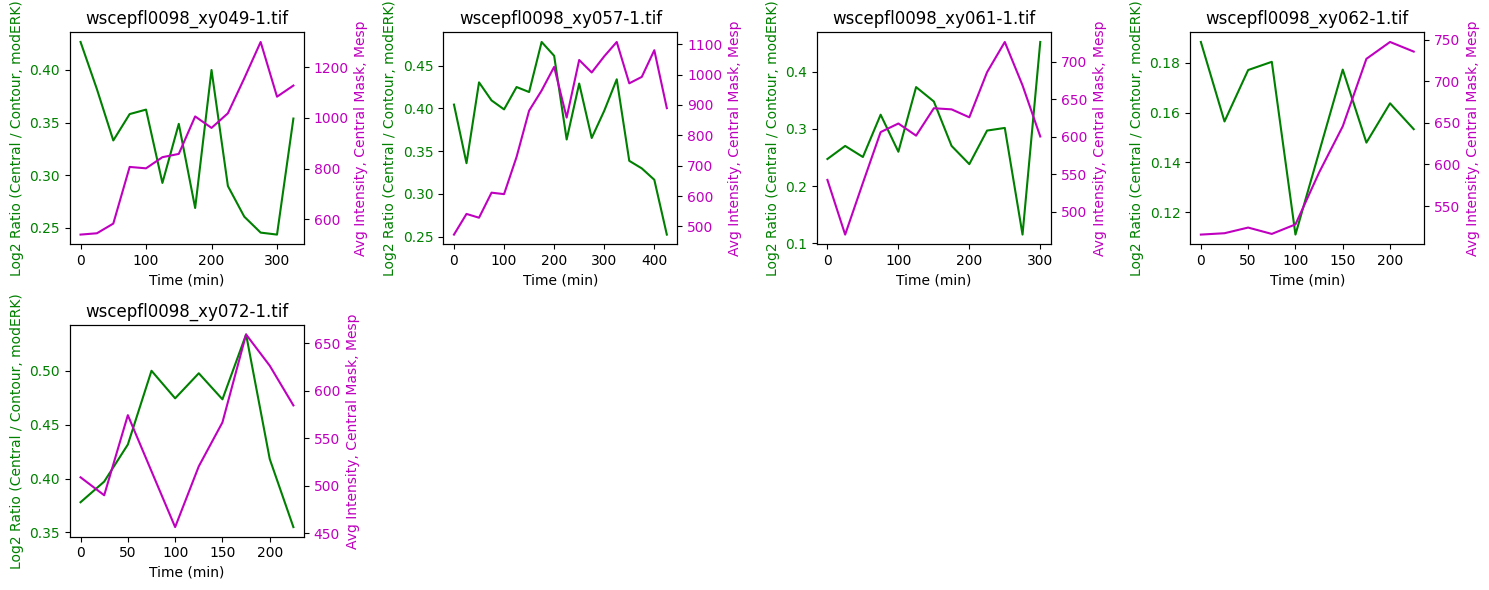

In [206]:
#plot all cells pd-17

time_interval = 25

# Get all keys in the result dictionary
keys_list = sorted(result_pd17.keys())
num_keys = len(keys_list)

# Create subplots
num_columns = 4  # You can adjust this based on your needs
num_rows = (num_keys + num_columns - 1) // num_columns  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result_pd17[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result_pd17[keys_list[position_nu]]['ratio_list']
    channel_3_avg_list = result_pd17[keys_list[position_nu]]['channel_3_avg_list']

    # Plot the central-to-contour intensity ratio over time in log2 scale
    ax1 = axes[position_nu]  # Current axis for the current key
    ax1.plot(np.array(num_timepoints) * time_interval, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
    ax1.set_xlabel('Time (min)')
    # Set the x-axis range from 0 to 1000 and set x-ticks at intervals of 240
    #ax1.set_xlim(0, 1000)
    #ax1.set_xticks(np.arange(0, 1001, 240))  # Ticks at intervals of 240
    
    ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
    #ax1.set_ylim(-0.3,0.5)
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Step 3: Create a second y-axis for Channel 3 average intensity
    ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis
    ax2.plot(np.array(num_timepoints) * time_interval, channel_3_avg_list, color='m', label='Avg Intensity, Central Mask, Ch3')
    ax2.set_ylabel('Avg Intensity, Central Mask, Mesp', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    # Final touches for the plot
    ax1.set_title(keys_list[position_nu])

# Hide any empty subplots if there are any
for empty_idx in range(num_keys, num_rows * num_columns):
    fig.delaxes(axes[empty_idx])

# Adjust layout so that labels don't overlap
fig.tight_layout()  
plt.show()


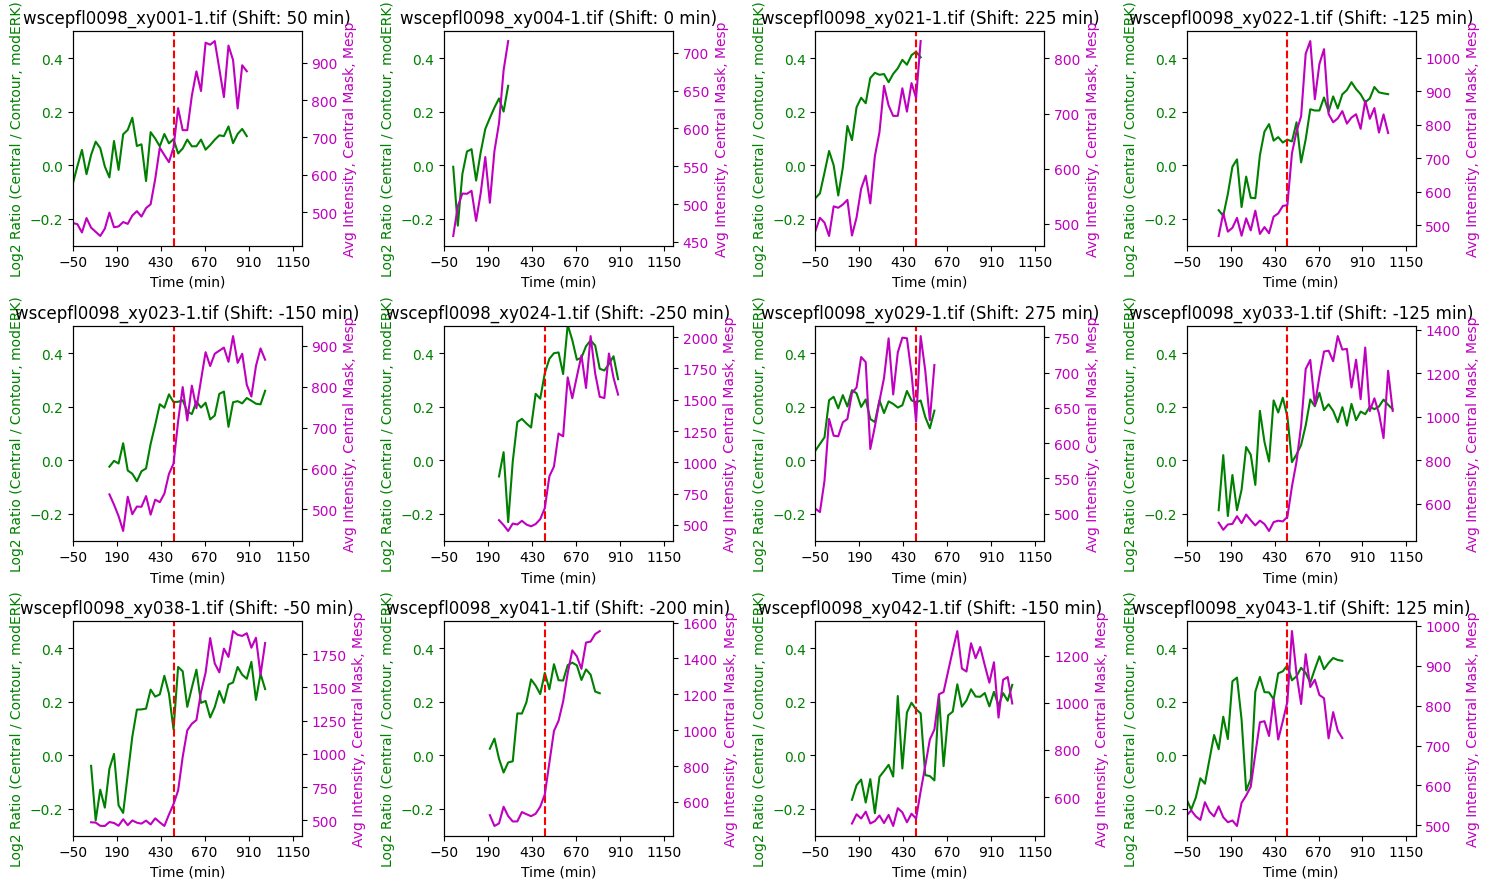

In [149]:
# shift values after finding the rising point of mesp (a difference of 100 a.u. between two points)

time_interval = 25

# Get all keys in the result dictionary
keys_list = sorted(result.keys())
num_keys = len(keys_list)

# Create subplots
num_columns = 4  # You can adjust this based on your needs
num_rows = (num_keys + num_columns - 1) // num_columns  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define a reference point to align all rising points (e.g., position 500)
align_time = 500

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result[keys_list[position_nu]]['ratio_list']
    channel_3_avg_list = result[keys_list[position_nu]]['channel_3_avg_list']
    
    # Step 1: Find the rising point in channel_3_avg_list
    diff_channel_3 = np.diff(channel_3_avg_list)  # Calculate differences
    rising_points = np.where(diff_channel_3 > 100)[0]  # Find where the change > 100

    if len(rising_points) > 0:
        rising_point = rising_points[0]  # Take the first rising point
        shift = rising_point * time_interval - align_time  # Calculate the shift
        shifted_rising_point_time = rising_point * time_interval - shift  # Adjust the rising point position based on the shift
    else:
        shift = 0  # No rising point found, no shift
        shifted_rising_point_time = None  # No rising point to plot

    # Step 2: Plot the central-to-contour intensity ratio over time in log2 scale
    ax1 = axes[position_nu]  # Current axis for the current key
    ax1.plot((np.array(num_timepoints) * time_interval) - shift, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
    ax1.set_xlabel('Time (min)')
    ax1.set_xlim(-50, 1200)  # Adjust x-axis to ensure proper alignment
    ax1.set_xticks(np.arange(-50, 1201, 240))  # Ticks at intervals of 240

    ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
    ax1.set_ylim(-0.3, 0.5)
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Add a vertical line at the shifted rising point
    if shifted_rising_point_time is not None:
        ax1.axvline(x=shifted_rising_point_time, color='r', linestyle='--', label='Rising Point')

    # Step 3: Create a second y-axis for Channel 3 average intensity
    ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis
    ax2.plot((np.array(num_timepoints) * time_interval) - shift, channel_3_avg_list, color='m', label='Avg Intensity, Central Mask, Ch3')
    ax2.set_ylabel('Avg Intensity, Central Mask, Mesp', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    # Final touches for the plot
    ax1.set_title(f'{keys_list[position_nu]} (Shift: {shift} min)')

# Hide any empty subplots if there are any
for empty_idx in range(num_keys, num_rows * num_columns):
    fig.delaxes(axes[empty_idx])

# Adjust layout so that labels don't overlap
fig.tight_layout()  
plt.show()


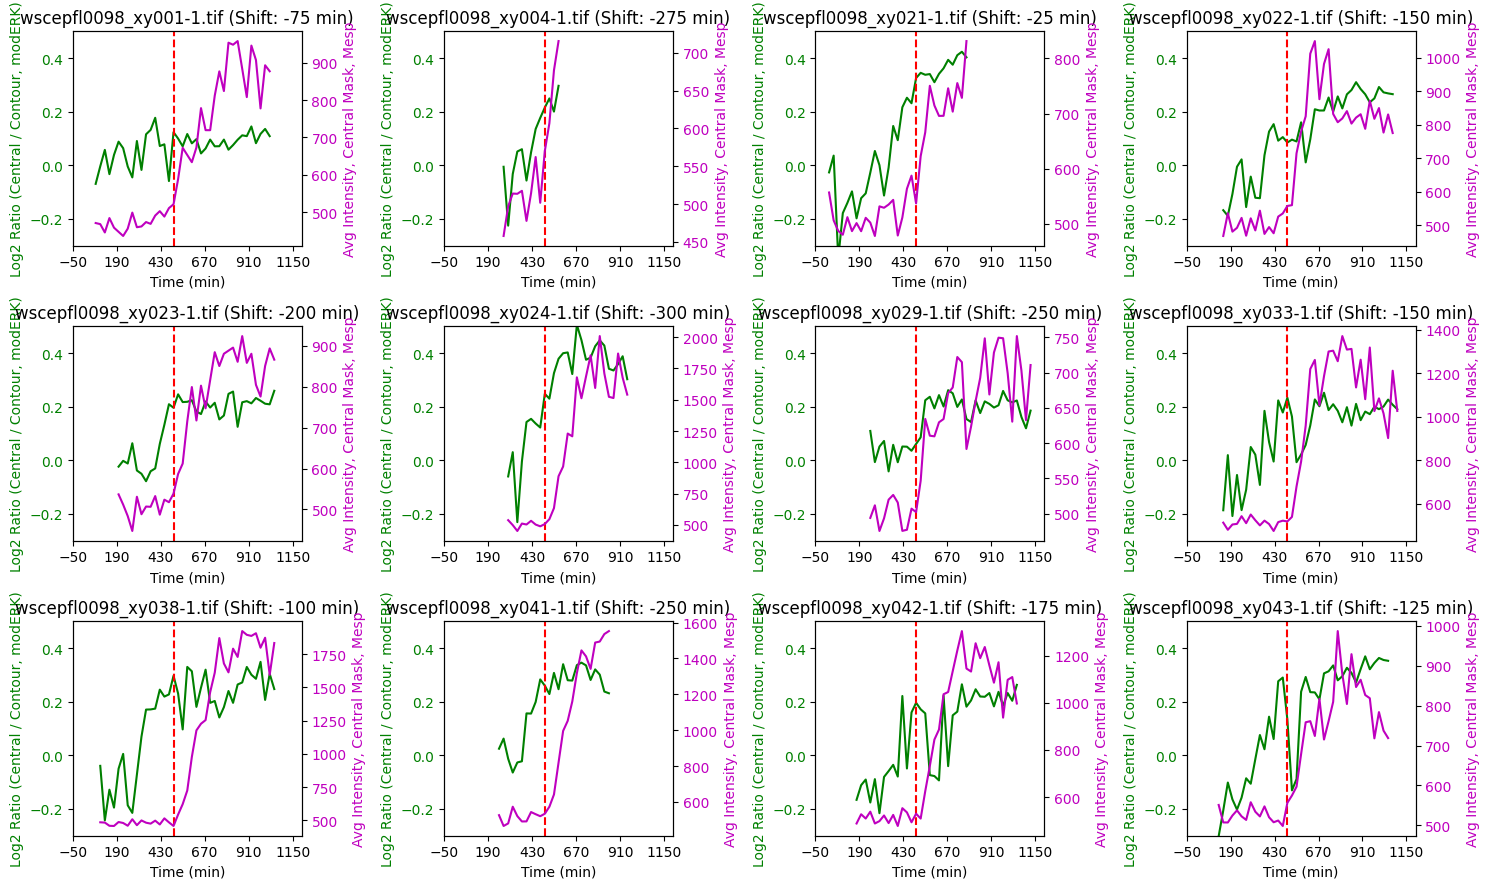

In [175]:
# alternative, smooth the data before detecting shift (more correct)

time_interval = 25
smoothing_window = 5  # You can adjust this based on the desired level of smoothing

# Get all keys in the result dictionary
keys_list = sorted(result.keys())
num_keys = len(keys_list)

# Create subplots
num_columns = 4  # Adjust this based on your needs
num_rows = (num_keys + num_columns - 1) // num_columns  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Define a reference point to align all rising points (e.g., position 500)
align_time = 500

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result[keys_list[position_nu]]['ratio_list']
    channel_3_avg_list = result[keys_list[position_nu]]['channel_3_avg_list']
    
    # Step 1: Smooth the channel_3_avg_list before finding the rising point
    smoothed_channel_3 =gaussian_filter1d(channel_3_avg_list, sigma=1)
    
    # Step 2: Find the rising point in the smoothed data
    diff_channel_3 = np.diff(smoothed_channel_3)  # Calculate differences
    rising_points = np.where(diff_channel_3 > 30)[0]  # Find where the change > 100

    if len(rising_points) > 0:
        rising_point = rising_points[0]  # Take the first rising point
        shift = rising_point * time_interval - align_time  # Calculate the shift
        shifted_rising_point_time = rising_point * time_interval - shift  # Adjust the rising point position based on the shift
    else:
        shift = 0  # No rising point found, no shift
        shifted_rising_point_time = None  # No rising point to plot

    # Step 3: Plot the central-to-contour intensity ratio over time in log2 scale
    ax1 = axes[position_nu]  # Current axis for the current key
    ax1.plot((np.array(num_timepoints) * time_interval) - shift, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
    ax1.set_xlabel('Time (min)')
    ax1.set_xlim(-50, 1200)  # Adjust x-axis to ensure proper alignment
    ax1.set_xticks(np.arange(-50, 1201, 240))  # Ticks at intervals of 240

    ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
    ax1.set_ylim(-0.3, 0.5)
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Add a vertical line at the shifted rising point
    if shifted_rising_point_time is not None:
        ax1.axvline(x=shifted_rising_point_time, color='r', linestyle='--', label='Rising Point')

    # Step 4: Create a second y-axis for Channel 3 average intensity
    ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis
    ax2.plot((np.array(num_timepoints) * time_interval) - shift, channel_3_avg_list, color='m', label='Avg Intensity, Central Mask, Ch3')
    ax2.set_ylabel('Avg Intensity, Central Mask, Mesp', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
    
    # Final touches for the plot
    ax1.set_title(f'{keys_list[position_nu]} (Shift: {shift} min)')

# Hide any empty subplots if there are any
for empty_idx in range(num_keys, num_rows * num_columns):
    fig.delaxes(axes[empty_idx])

# Adjust layout so that labels don't overlap
fig.tight_layout()  
plt.show()


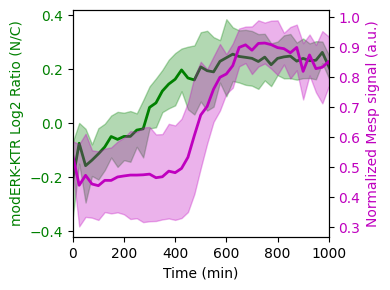

In [188]:
# calculate mean +/- std of the positions after smoothed shifting

time_interval = 25
align_time = 430

# Get all keys in the result dictionary
keys_list = sorted(result.keys())
num_keys = len(keys_list)

# Initialize lists to hold the shifted, normalized data
all_norm_channel_3 = []
all_log2_ratio = []
max_length = 0

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result[keys_list[position_nu]]['ratio_list']
    channel_3_avg_list = result[keys_list[position_nu]]['channel_3_avg_list']
    
    # Smooth the channel_3_avg_list using a Gaussian filter
    smoothed_channel_3 = gaussian_filter1d(channel_3_avg_list, sigma=1)

    # Step 1: Find the rising point in smoothed_channel_3
    diff_channel_3 = np.diff(smoothed_channel_3)  # Calculate differences
    rising_points = np.where(diff_channel_3 > 30)[0]  # Find where the change > 100

    if len(rising_points) > 0:
        rising_point = rising_points[0]  # Take the first rising point
        shift = rising_point * time_interval - align_time  # Calculate the shift
    else:
        shift = 0  # No rising point found, no shift

    # Shift the time axis
    shifted_time = (np.array(num_timepoints) * time_interval) - shift

    # Normalize channel_3_avg_list by its maximum value
    norm_channel_3 = channel_3_avg_list / np.max(channel_3_avg_list)

    # Log2 transform the ratio list
    log2_ratio = np.log2(ratio_list)

    # Pad the shifted data to ensure consistent length across all keys
    max_time = 1200  # Set the maximum time for plotting
    max_index = int(max_time // time_interval)  # Convert time to index
    padded_norm_channel_3 = np.full(max_index, np.nan)
    padded_log2_ratio = np.full(max_index, np.nan)
    
    # Find the range of valid indices for the current data
    valid_idx = (shifted_time >= 0) & (shifted_time < max_time)
    indices = (shifted_time[valid_idx] // time_interval).astype(int)

    # Insert the valid values into the padded arrays
    padded_norm_channel_3[indices] = norm_channel_3[valid_idx]
    padded_log2_ratio[indices] = log2_ratio[valid_idx]

    all_norm_channel_3.append(padded_norm_channel_3)
    all_log2_ratio.append(padded_log2_ratio)

# Convert to numpy arrays
all_norm_channel_3 = np.array(all_norm_channel_3)
all_log2_ratio = np.array(all_log2_ratio)

# Step to avoid empty slices: ignore columns where all values are NaN
valid_columns_norm_channel_3 = np.all(np.isnan(all_norm_channel_3), axis=0) == False
valid_columns_log2_ratio = np.all(np.isnan(all_log2_ratio), axis=0) == False

# Calculate the mean and standard deviation, ignoring NaN values
mean_norm_channel_3 = np.nanmean(all_norm_channel_3[:, valid_columns_norm_channel_3], axis=0)
std_norm_channel_3 = np.nanstd(all_norm_channel_3[:, valid_columns_norm_channel_3], axis=0)

mean_log2_ratio = np.nanmean(all_log2_ratio[:, valid_columns_log2_ratio], axis=0)
std_log2_ratio = np.nanstd(all_log2_ratio[:, valid_columns_log2_ratio], axis=0)

# Adjust the time axis for valid data
time_axis_norm_channel_3 = time_axis[valid_columns_norm_channel_3]
time_axis_log2_ratio = time_axis[valid_columns_log2_ratio]

# Plot the results
fig, ax1 = plt.subplots(figsize=(4, 3))

# Plot log2_ratio with mean and std
ax1.plot(time_axis_log2_ratio, mean_log2_ratio, color='g', label='Mean Log2 Ratio (modERK)', lw=2)
ax1.fill_between(time_axis_log2_ratio, mean_log2_ratio - std_log2_ratio, mean_log2_ratio + std_log2_ratio, color='g', alpha=0.3)
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('modERK-KTR Log2 Ratio (N/C)', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xlim([0,1000])
ax1.set_ylim([-0.42,0.42])

# Create a second y-axis for normalized channel 3 average intensity
ax2 = ax1.twinx()
ax2.plot(time_axis_norm_channel_3, mean_norm_channel_3, color='m', label='Mean Normalized Mesp', lw=2)
ax2.fill_between(time_axis_norm_channel_3, mean_norm_channel_3 - std_norm_channel_3, mean_norm_channel_3 + std_norm_channel_3, color='m', alpha=0.3)
ax2.set_ylabel('Normalized Mesp signal (a.u.)', color='m')
ax2.tick_params(axis='y', labelcolor='m')

# Add the number of positions below the plot
#plt.text(0.5, -0.4, f'n={num_keys} positions', ha='center', va='center', transform=ax1.transAxes, fontsize=12)

fig.tight_layout()
plt.show()

### for images with H2B in Channel 3 and modERK in Channel 2



In [129]:

def extract_cyto_by_subtraction(mask_erk, mask_nuc):

    # Step 1: Erode the mask by 'width' pixels
    mask_erk = binary_erosion(mask_erk, iterations=2) # to erode the mask before defining contour (optional)
    # Step 2: Subtract the eroded mask from the original mask to get the contour
    mask_nuc = binary_dilation(mask_nuc) # to dilate the mask before defining contour (optional)
    mask_cyto = mask_erk.astype(np.int16) - mask_nuc.astype(np.int16)
    
    return mask_cyto

def create_nuc_mask(mask_nuc):

    mask_nuc = binary_erosion(mask_nuc, iterations=1) # to erode the mask
    return mask_nuc

def read_tif_and_mask(image_erk_path, image_nuc_path, mask_erk_path, mask_nuc_path):
    # Read the channel2 TIF file
    image_erk = imread(image_erk_path)
    # Read the channel3 TIF file
    image_nuc = imread(image_nuc_path)
    
    # Load the masks NumPy array
    mask_erk = np.load(mask_erk_path)
    mask_nuc = np.load(mask_nuc_path)
    
    # Binarize the mask (bg=2 and mask=1 in original array)
    mask_erk = np.where(mask_erk == 2, 0, mask_erk)
    mask_nuc = np.where(mask_nuc == 2, 0, mask_nuc)

    for t in range(mask_erk.shape[0]):  # Fill holes for each time frame
        mask_erk[t] = binary_fill_holes(mask_erk[t]).astype(np.uint8)
        mask_nuc[t] = binary_fill_holes(mask_nuc[t]).astype(np.uint8)
      
    # Initialize lists to store masks and results for each time point
    central_region_mask_list = []
    contour_mask_list = []
    ratio_list = []

    num_timepoints = image_erk.shape[0]
  # Process each time point
    for t in range(num_timepoints):
        # Get the current mask for this time point
        central_region_mask = mask_nuc[t,:,:,0]
        central_region_mask = create_nuc_mask(central_region_mask)
        central_region_mask_list.append(central_region_mask)
        
        # Step 3: Extract the contour mask for the current frame
        contour_mask = mask_erk[t,:,:,0]
        contour_mask = extract_cyto_by_subtraction(contour_mask, central_region_mask)
        contour_mask_list.append(contour_mask)
        
        # Get the current frame of the image 
        current_frame_channel_2 = image_erk[t]
        
        # Calculate average intensity in the central region and contour region (Channel 2)
        central_avg_intensity = np.mean(current_frame_channel_2[central_region_mask == 1])
        contour_avg_intensity = np.mean(current_frame_channel_2[contour_mask == 1])
        
        # Calculate the ratio for Channel 2 and append it to the list
        if contour_avg_intensity != 0:
            ratio = central_avg_intensity / contour_avg_intensity
        else:
            ratio = np.nan  # Avoid division by zero
        ratio_list.append(ratio)
        
    return num_timepoints, ratio_list, central_region_mask_list, contour_mask_list


def moving_average_same_size(data, window_size=5):
    # Compute the moving average using 'same' mode to maintain array size
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='same')
    return smoothed

def process_all_files_in_folder(folder_path):
    
    # Initialize an empty dictionary to store results
    result_dict = {}
    
    # Loop over all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('-ch2.tif'):
            # Construct the full path to the TIF file
            image_erk_path = os.path.join(folder_path, file_name)
            image_nuc_file_name = file_name.replace('-ch2.tif', '-ch3.tif')
            image_nuc_path = os.path.join(folder_path, image_nuc_file_name)
            # Find the corresponding mask file (replace '.tif' with '-ch2_Simple Segmentation.npy')
            mask_erk_file_name = file_name.replace('.tif', '_Simple Segmentation.npy')
            mask_erk_path = os.path.join(folder_path, mask_erk_file_name)
            mask_nuc_file_name = file_name.replace('2.tif', '3_Simple Segmentation.npy')
            mask_nuc_path = os.path.join(folder_path, mask_nuc_file_name)
            num_timepoints, ratio_list, central_region_mask_list, contour_mask_list = read_tif_and_mask(image_erk_path, image_nuc_path, mask_erk_path, mask_nuc_path)
                                                                                    
            # Store the values in the dictionary with the file name as key
            result_dict[file_name] = {
                'num_timepoints': num_timepoints,
                'ratio_list': ratio_list,
                'central_region_mask_list': central_region_mask_list,
                'contour_mask_list': contour_mask_list
                }
            print (f"{file_name} completed")

    
    # Return the result dictionary
    return result_dict

# Call the function and store the result
result = process_all_files_in_folder('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0120/ilastik')

# Now `result` contains all the processed data in a dictionary structure.



wscepfl0120_xy34-ch2.tif completed
wscepfl0120_xy24-ch2.tif completed
wscepfl0120_xy12-ch2.tif completed
wscepfl0120_xy02-ch2.tif completed
wscepfl0120_xy03-ch2.tif completed
wscepfl0120_xy13-ch2.tif completed
wscepfl0120_xy25-ch2.tif completed
wscepfl0120_xy35-ch2.tif completed
wscepfl0120_xy11-ch2.tif completed
wscepfl0120_xy01-ch2.tif completed
wscepfl0120_xy19-ch2.tif completed
wscepfl0120_xy26-ch2.tif completed
wscepfl0120_xy10-ch2.tif completed
wscepfl0120_xy06-2-ch2.tif completed
wscepfl0120_xy15-ch2.tif completed
wscepfl0120_xy05-ch2.tif completed
wscepfl0120_xy33-ch2.tif completed
wscepfl0120_xy23-ch2.tif completed
wscepfl0120_xy22-ch2.tif completed
wscepfl0120_xy32-ch2.tif completed
wscepfl0120_xy04-ch2.tif completed
wscepfl0120_xy14-ch2.tif completed
wscepfl0120_xy30-ch2.tif completed
wscepfl0120_xy20-ch2.tif completed
wscepfl0120_xy29-ch2.tif completed
wscepfl0120_xy16-2-ch2.tif completed
wscepfl0120_xy16-ch2.tif completed
wscepfl0120_xy06-ch2.tif completed
wscepfl0120_xy28

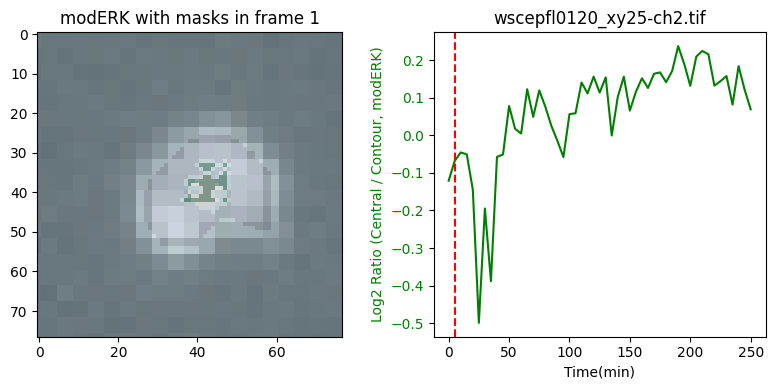

In [132]:
# enter the frame number and time point you want to visualize
position_nu = 6
time_point = 1
time_interval =5


keys_list = list(result.keys())
num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
ratio_list = result[keys_list[position_nu]]['ratio_list']

# Step 1: Plot the first frame (Channel 2) with contour and central mask from the first frame
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
# Display the frame of the TIF file (Channel 2)
image = imread('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0120/ilastik/'+keys_list[position_nu])
current_frame_channel_2 = image[time_point]
axes[0].imshow(current_frame_channel_2, cmap='gray')
    
# Overlay the central region with transparency
axes[0].imshow(result[keys_list[position_nu]]['central_region_mask_list'][time_point], cmap='Greens', alpha=0.4)
    
# Overlay the contour with transparency
axes[0].imshow(result[keys_list[position_nu]]['contour_mask_list'][time_point], cmap='Blues', alpha=0.2)   
axes[0].set_title(f'modERK with masks in frame {time_point:.0f}')



# Step 2: Plot the central-to-contour intensity ratio over time in log2 scale
ax1 = axes[1]  # First y-axis
ax1.plot(np.array(num_timepoints)*time_interval, np.log2(ratio_list), color='g', label='Log2(Central / Contour, Ch2)')
ax1.set_xlabel('Time(min)')
ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
ax1.tick_params(axis='y', labelcolor='g')
# Add a vertical line at the specified time point
ax1.axvline(x=time_point * time_interval, color='r', linestyle='--', label='Time Point Line')

   
# Final touches for the plot
ax1.set_title(keys_list[position_nu])
fig.tight_layout()  # Adjust layout so that labels don't overlap
    
plt.show()

In [18]:
result['wscepfl0120_xy34-ch2.tif'].keys()


dict_keys(['num_timepoints', 'ratio_list', 'central_region_mask_list', 'contour_mask_list'])

In [57]:
mask = extract_cyto_by_subtraction(erk,nuc)

In [35]:
erk = np.load('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0120/ilastik/wscepfl0120_xy21-ch2_Simple Segmentation.npy')

In [198]:
nuc = np.load('/Users/fnarslan/Desktop/RohdeSSD-copies/wscepfl0120/ilastik/wscepfl0120_xy23-ch3_Simple Segmentation.npy')

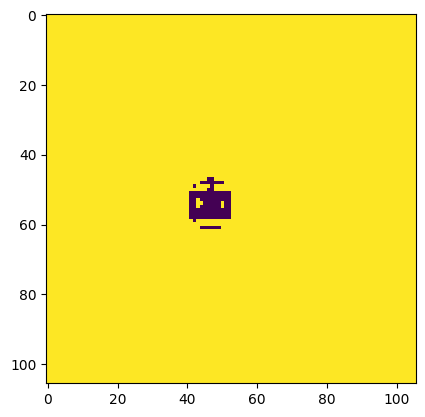

In [200]:
plt.imshow(nuc[50])

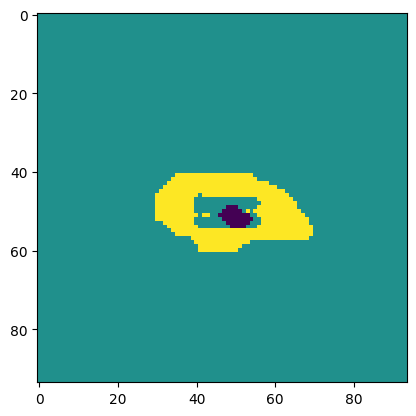

In [75]:
plt.imshow(result[keys_list[position_nu]]['contour_mask_list'][time_point])

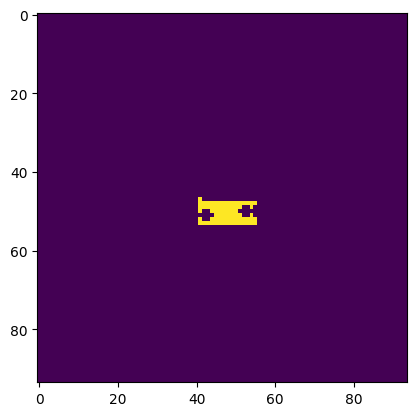

In [76]:
plt.imshow(result[keys_list[position_nu]]['central_region_mask_list'][time_point])

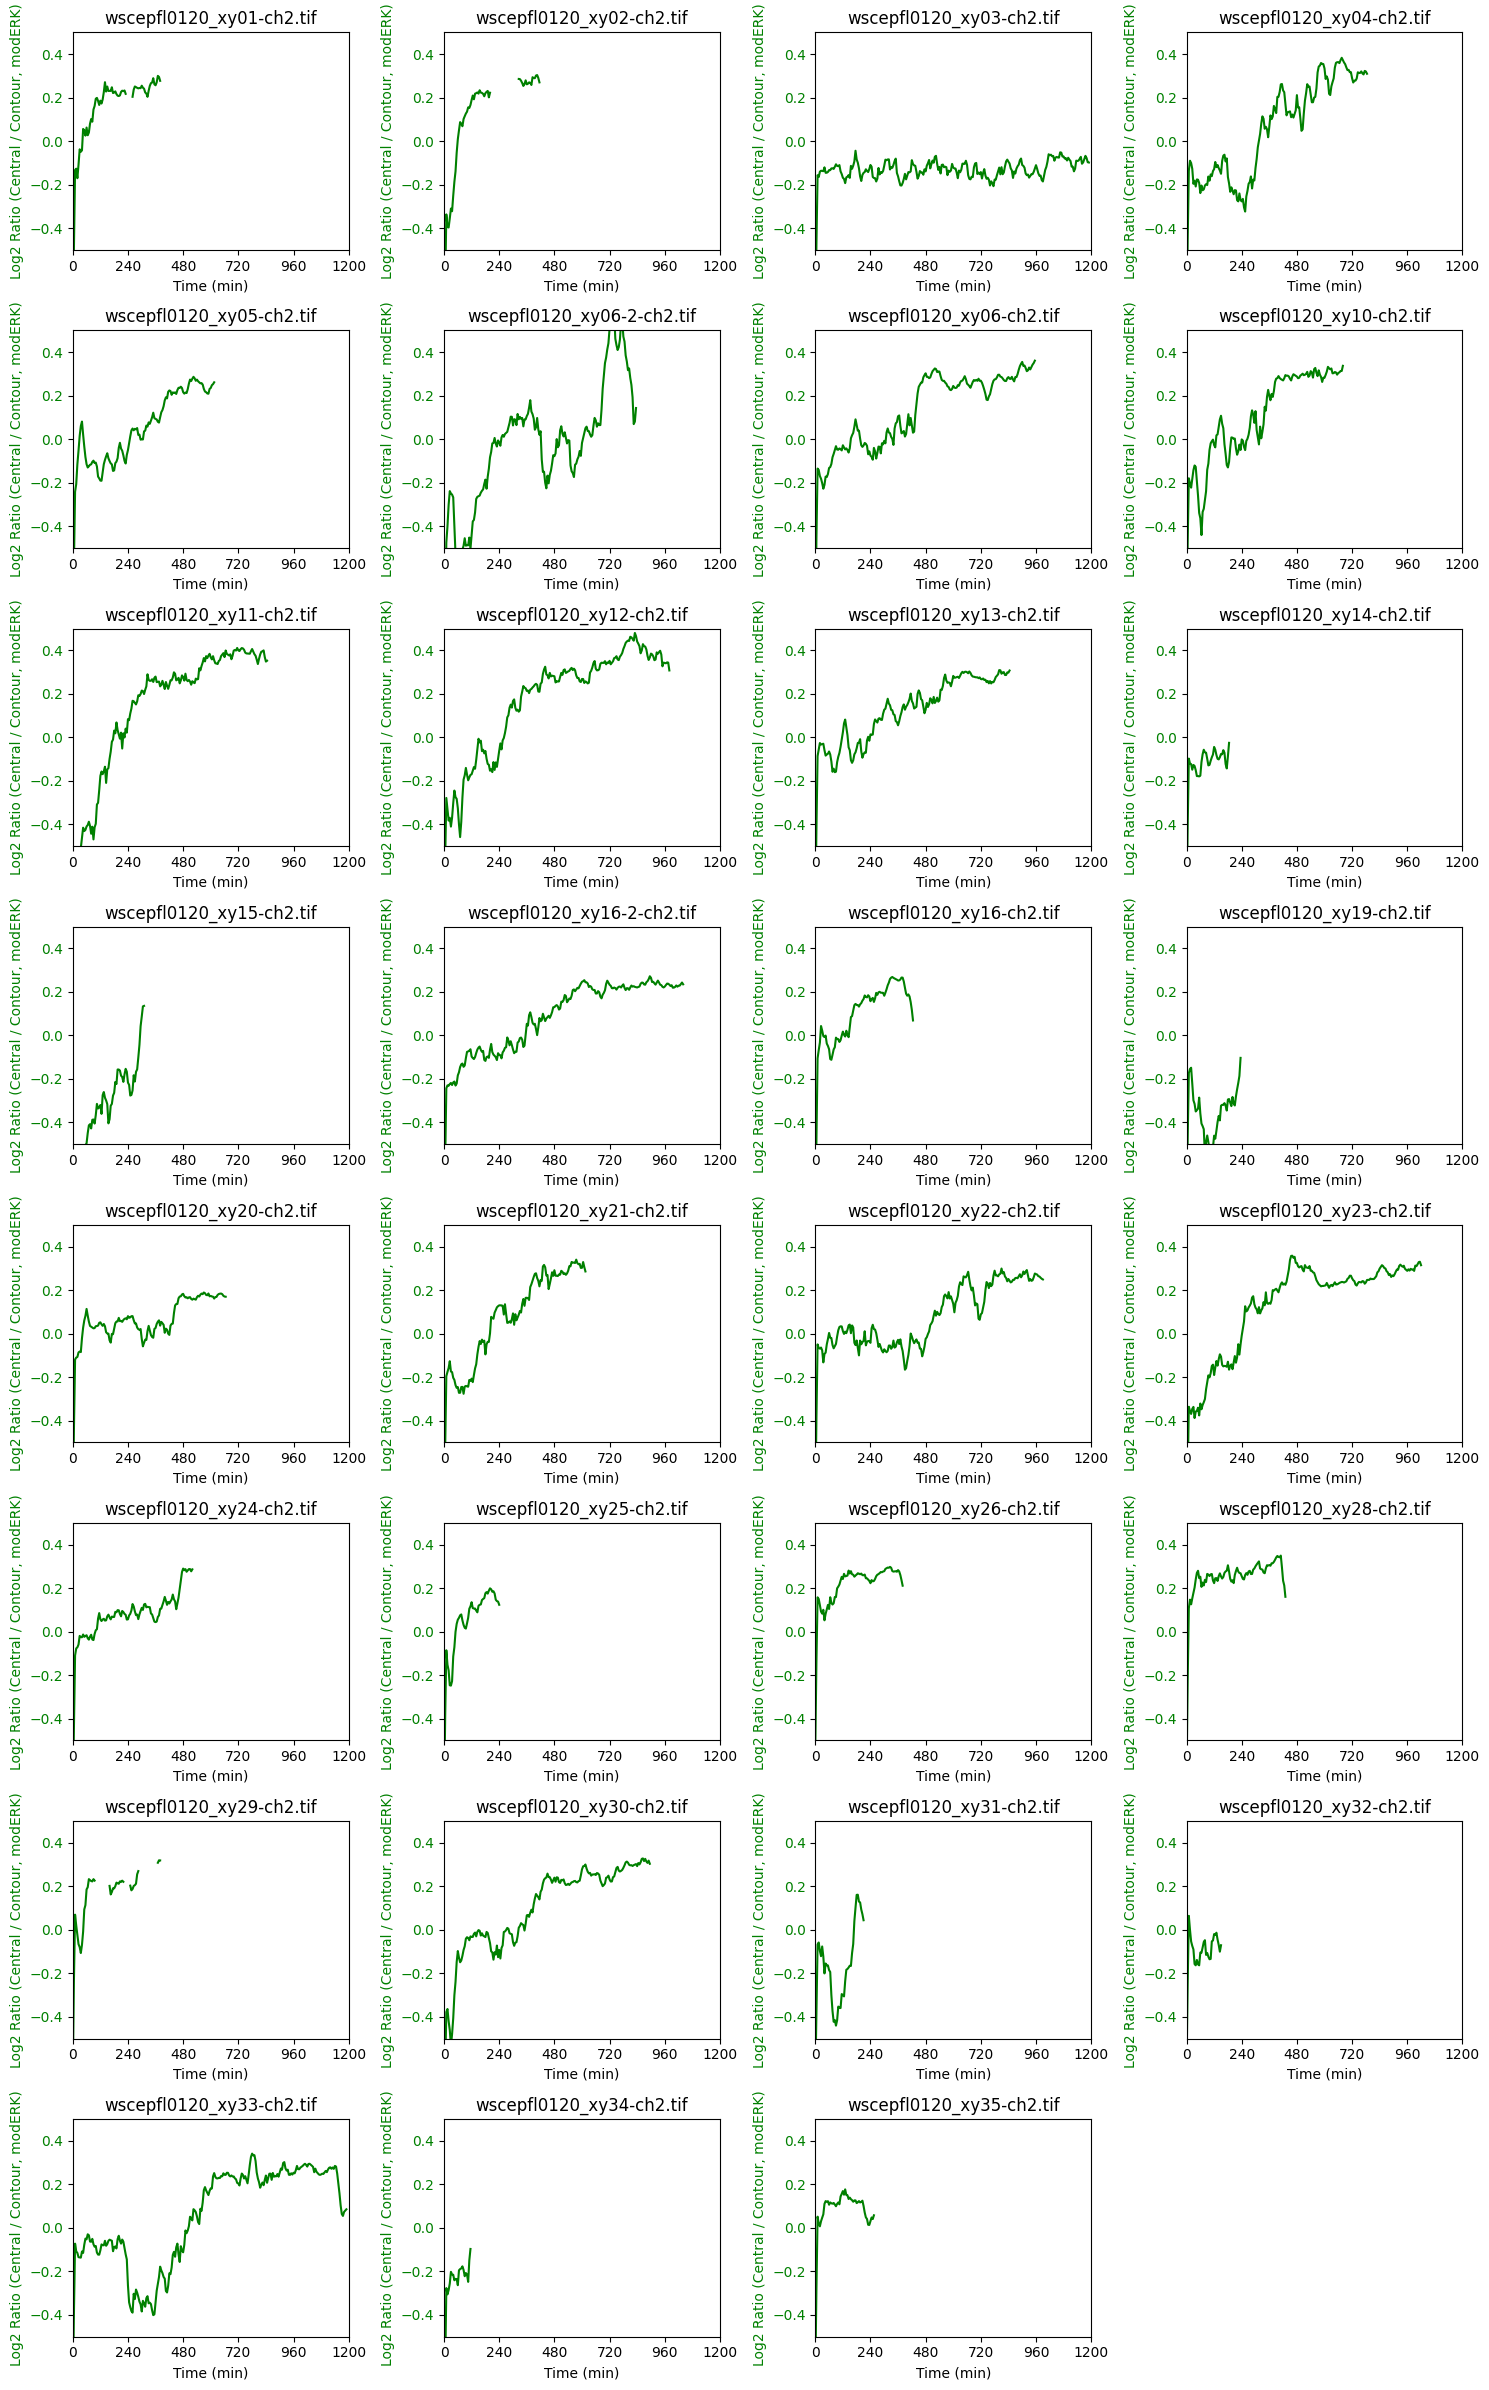

In [90]:
time_interval = 5

# Get all keys in the result dictionary
keys_list = sorted(result.keys())
num_keys = len(keys_list)

# Create subplots
num_columns = 4  # You can adjust this based on your needs
num_rows = (num_keys + num_columns - 1) // num_columns  # Calculate required rows
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for position_nu in range(num_keys):
    # Access data for the current key
    num_timepoints = np.arange(result[keys_list[position_nu]]['num_timepoints'])
    ratio_list = result[keys_list[position_nu]]['ratio_list']

    #smooth
    window_size = 5  # You can adjust this value
    ratio_list = result[keys_list[position_nu]]['ratio_list']
    ratio_list = moving_average_same_size(ratio_list, window_size)
    
    # Plot the central-to-contour intensity ratio over time in log2 scale
    ax1 = axes[position_nu]  # Current axis for the current key
    ax1.plot(np.array(num_timepoints[:-2]) * time_interval, np.log2(ratio_list[:-2]), color='g', label='Log2(Central / Contour, Ch2)')
    ax1.set_xlabel('Time (min)')
    # Set the x-axis range from 0 to 1000 and set x-ticks at intervals of 240
    ax1.set_xlim(0, 1200)
    ax1.set_xticks(np.arange(0, 1201, 240))  # Ticks at intervals of 240
    
    ax1.set_ylabel('Log2 Ratio (Central / Contour, modERK)', color='g')
    ax1.set_ylim(-0.5,0.5)
    ax1.tick_params(axis='y', labelcolor='g')
    
    # Final touches for the plot
    ax1.set_title(keys_list[position_nu])

# Hide any empty subplots if there are any
for empty_idx in range(num_keys, num_rows * num_columns):
    fig.delaxes(axes[empty_idx])

# Adjust layout so that labels don't overlap
fig.tight_layout()  
plt.show()
